In [19]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [3]:

# Compute error rate, alpha and w

def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation
    
    Note that all arrays should be the same length
    NB: remember that the sum of the error has to be 1
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))


In [23]:
# Define AdaBoost class
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            # An estimator is an object that fits a model based
            # on some training data and is capable of inferring some properties on new data.
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)
    
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred
    
    def error_rates(self, X, y):
        '''
        Get the error rates of each weak classifier. Arguments:
        X: independent variables
        y: target variables associated to X
        '''
        
        self.prediction_errors = [] # Clear before calling
        
        # Predict class label for each weak classifier
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X)          
            error_m = compute_error(y = y, y_pred = y_pred_m, w_i = np.ones(len(y)))
            self.prediction_errors.append(error_m)

In [24]:
# Dataset
from sklearn.model_selection import train_test_split
import pandas as pd


df = pd.read_csv('./spambase.data', header = None)

# Column names
names = pd.read_csv('./spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')

# Rename df columns
df.columns = col_names

# Convert classes in target variable to {-1, 1}
df['Spam'] = df['Spam'] * 2 - 1

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, 
                                                    df['Spam'].values, 
                                                    train_size = 3065, 
                                                    random_state = 2) 

In [25]:
# Fit model
ab = AdaBoost()
ab.fit(X_train, y_train, M = 400)

# Predict on test set
y_pred = ab.predict(X_test)

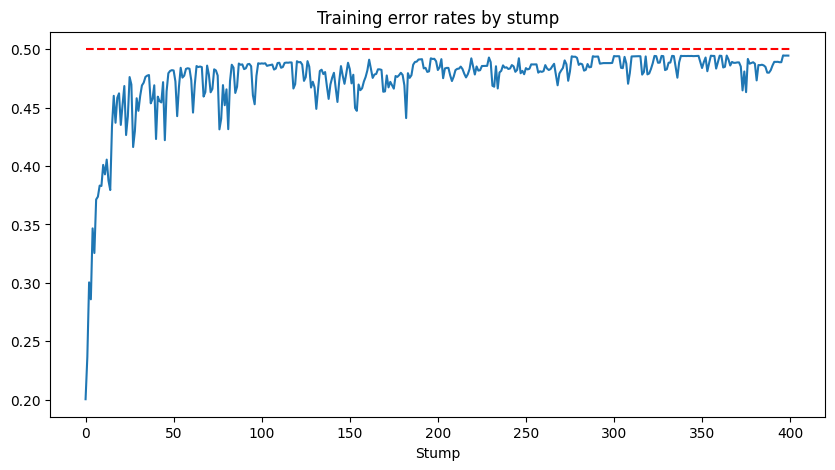

In [26]:
# Error rates during training
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

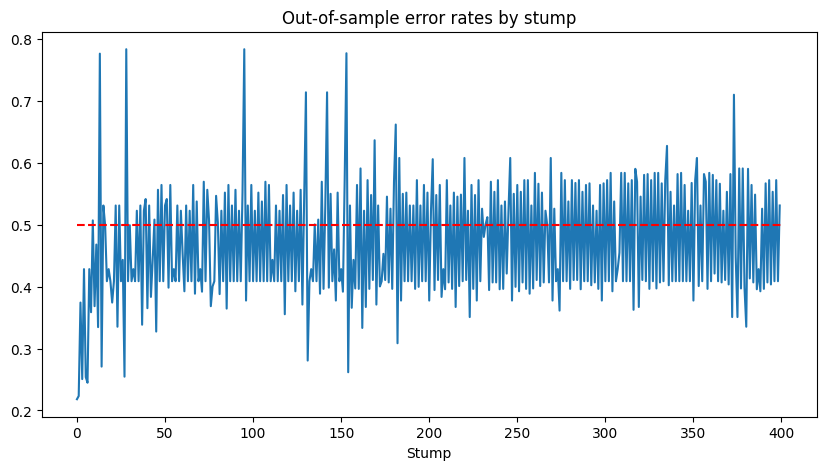

In [27]:
# Error rates out of sample
ab.error_rates(X_test, y_test)
plt.figure(figsize=(10,5))
plt.plot(ab.prediction_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Out-of-sample error rates by stump')
plt.xlabel('Stump')
plt.show()

In [28]:
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation

    
    Note that all arrays should be the same length
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

print('Error rate of metaclassifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

Error rate of metaclassifier: 0.056
